## Geo-Python 2021 Final Exercise
### Bruno M. Carvalho (16/02/2022)
The final exercise in the Geo-Python course involves calculating and plotting seasonal weather anomalies to see how temperatures have changed in different seasons over the past 100+ years. We will be using weather data from the Sodankylä weather station in northern Finland.

The data file contains daily temperature data from January 1908 to October 2020. The data was downloaded from the [NOAA Global Historical Climate Network database](https://www.ncdc.noaa.gov/cdo-web/datasets#GHCND) as a text file. Temperature values are in Fahrenheit and missing values are represented as "-9999".

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### 1. Read the data
Making sure to add the features of the original data file and identify missing values.

In [2]:
data = pd.read_csv(
    "data/2315676.txt",
    delim_whitespace=True,
    skiprows=[1],
    na_values=[-9999],
    parse_dates=['DATE']
    )

Check if everything is ok:

In [3]:
data.head()

,STATION,STATION_NAME,DATE,TAVG,TMAX,TMIN
0,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-01,NaN,2.0,-37.0
1,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-02,NaN,6.0,-26.0
2,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-03,NaN,7.0,-27.0
3,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-04,NaN,-3.0,-27.0
4,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-05,NaN,4.0,-36.0


In [4]:
data.tail()

,STATION,STATION_NAME,DATE,TAVG,TMAX,TMIN
41060,GHCND:FI000007501,SODANKYLA-AWS-FI,2020-10-03,47.0,51.0,NaN
41061,GHCND:FI000007501,SODANKYLA-AWS-FI,2020-10-04,43.0,47.0,37.0
41062,GHCND:FI000007501,SODANKYLA-AWS-FI,2020-10-05,42.0,NaN,37.0
41063,GHCND:FI000007501,SODANKYLA-AWS-FI,2020-10-06,45.0,46.0,43.0
41064,GHCND:FI000007501,SODANKYLA-AWS-FI,2020-10-07,47.0,50.0,44.0


In [5]:
# Check if all the data comes from a single station
data['STATION_NAME'].unique()

array(['SODANKYLA-AWS-FI'], dtype=object)

The TAVG column has some missing values that can be estimated from TMAX and TMIN.

### 2. Fill in the missing values of daily average temperature (TAVG)

In [6]:
# Calculating average daily temperatures from TMAX and TMIN
data['TAVG_CALC'] = (data['TMAX'] + data['TMIN']) / 2

data.head()

,STATION,STATION_NAME,DATE,TAVG,TMAX,TMIN,TAVG_CALC
0,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-01,NaN,2.0,-37.0,-17.5
1,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-02,NaN,6.0,-26.0,-10.0
2,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-03,NaN,7.0,-27.0,-10.0
3,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-04,NaN,-3.0,-27.0,-15.0
4,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-05,NaN,4.0,-36.0,-16.0


In [7]:
# Check for remaining missing values after the new estimates:
miss = data.loc[data['TAVG_CALC'].isna() == True]

print(f'We still have {len(miss)} rows of missing data in the new column TAVG_CALC')

We still have 2623 rows of missing data in the new column TAVG_CALC


In [8]:
# Drop the remaining rows with missing values in TAVG_CALC

# Quick check number of rows in df before removing NaN
print(f'Number of rows before missing data removal: {len(data)}')

# drop NaNs
data = data.dropna(subset=['TAVG_CALC'])

print(f'Number of rows after missing data removal: {len(data)}')

Number of rows before missing data removal: 41065
Number of rows after missing data removal: 38442


All temperature values are in Fahrenheit, so they need to be converted to Celsius.

### 3. Convert temperature values from Fahrenheit to Celsius

In [9]:
def fahr_to_celsius(temp_fahrenheit):
    """Converts temperature values from Fahrenheit to Celsius.
    
    Parameters:
    temp_fahrenheit = temperature in Fahrenheit (float)
    
    Return:
    temperature in celsius (float)
    """
    # Calculate the converted temperature value
    converted_temp = (temp_fahrenheit - 32) / 1.8
    
    # Return the converted value
    return converted_temp

And apply the new function over "TAVG_CALC" values:

In [10]:
data['TAVG_C'] = fahr_to_celsius(data['TAVG_CALC'])

data.head()

,STATION,STATION_NAME,DATE,TAVG,TMAX,TMIN,TAVG_CALC,TAVG_C
0,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-01,NaN,2.0,-37.0,-17.5,-27.500000
1,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-02,NaN,6.0,-26.0,-10.0,-23.333333
2,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-03,NaN,7.0,-27.0,-10.0,-23.333333
3,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-04,NaN,-3.0,-27.0,-15.0,-26.111111
4,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-05,NaN,4.0,-36.0,-16.0,-26.666667


Now we have the calculated daily average temperature in Celsius for the period 1908-2020. We need to aggregate the data by season.

The seasons should include the following months:

- Winter: December, January, February
- Spring: March, April, May
- Summer: June, July, August
- Autumn: September, October, November

### 4. Calculate seasonal monthly average temperatures

In [11]:
# Extract the month and year from 'DATE' for seasonal calculations
data['MONTH'] = data['DATE'].dt.month
data['YEAR'] = data['DATE'].dt.year

# define a season classifier function
def season(month):
    if month == 12 or month == 1 or month == 2:
        ssn = 'winter'
    elif month == 3 or month == 4 or month == 5:
        ssn = 'spring'
    elif month == 6 or month == 7 or month == 8:
        ssn = 'summer'
    elif month == 9 or month == 10 or month == 11:
        ssn = 'autumn'    
    return ssn

# apply the function into a new column
data['SEASON'] = data['MONTH'].apply(season)

# Create a combined season_year variable for later grouping
data['SEASON_YEAR'] = data['SEASON'] + "_" + data['YEAR'].astype(str)

data.head()

,STATION,STATION_NAME,DATE,TAVG,TMAX,TMIN,TAVG_CALC,TAVG_C,MONTH,YEAR,SEASON,SEASON_YEAR
0,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-01,NaN,2.0,-37.0,-17.5,-27.500000,1,1908,winter,winter_1908
1,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-02,NaN,6.0,-26.0,-10.0,-23.333333,1,1908,winter,winter_1908
2,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-03,NaN,7.0,-27.0,-10.0,-23.333333,1,1908,winter,winter_1908
3,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-04,NaN,-3.0,-27.0,-15.0,-26.111111,1,1908,winter,winter_1908
4,GHCND:FI000007501,SODANKYLA-AWS-FI,1908-01-05,NaN,4.0,-36.0,-16.0,-26.666667,1,1908,winter,winter_1908


In [12]:
# Group data and calculate monthly averages for each season
seasonal_avg = data.groupby('SEASON_YEAR').mean().reset_index()

# restore season column, which we will need for joining the reference values later
seasonal_avg['SEASON'] = seasonal_avg['SEASON_YEAR'].str.slice(stop=-5)

# adjust the year column, as it was "averaged" by the previous grouping step
seasonal_avg['YEAR'] = seasonal_avg['YEAR'].astype(int)

# keep only elevant columns
seasonal_avg = seasonal_avg[['SEASON_YEAR', 'TAVG_C', 'SEASON', 'YEAR']]

seasonal_avg

,SEASON_YEAR,TAVG_C,SEASON,YEAR
0,autumn_1908,-1.859217,autumn,1908
1,autumn_1909,-0.155827,autumn,1909
2,autumn_1910,-1.742063,autumn,1910
3,autumn_1911,-1.279150,autumn,1911
4,autumn_1912,-2.073413,autumn,1912
...,...,...,...,...
447,winter_2016,-12.615741,winter,2016
448,winter_2017,-10.208333,winter,2017
449,winter_2018,-11.937669,winter,2018
450,winter_2019,-10.612745,winter,2019


Now we need to calculate the average temperature values from the reference period (1951-1980), so that later they can be used to calculate the anomalies.

### 5. Calculate reference temperatures for 1951-1980

In [13]:
# subsetting the data to the reference period
ref_temps = seasonal_avg.loc[(seasonal_avg['YEAR'] >= 1951) & (seasonal_avg['YEAR'] <= 1980)]

# create de groups (identify grouping variable) and calculate grouped means
ref_temps = ref_temps.groupby('SEASON').mean().reset_index()

# rename columns to avoid confusion after joins
new_names = {"TAVG_C": "SEASON_REF_TAVG"}
ref_temps = ref_temps.rename(columns=new_names)

# keep only columns of interest
ref_temps = ref_temps[['SEASON', 'SEASON_REF_TAVG']]

ref_temps.head()

,SEASON,SEASON_REF_TAVG
0,autumn,-0.895838
1,spring,-2.655406
2,summer,12.181666
3,winter,-13.833583


### 6. Calculate the anomalies for 1909-2019

In [14]:
# filter to desired period
anomalies = seasonal_avg.loc[(seasonal_avg['YEAR'] >= 1909) & (seasonal_avg['YEAR'] <= 2019)]

# join the reference temp values to the seasonal averages
anomalies = anomalies.merge(ref_temps, on='SEASON', how='outer')

# calculate seasonal monthly anomalies
anomalies['SEASON_ANOM'] = anomalies['TAVG_C'] - anomalies['SEASON_REF_TAVG']

anomalies

,SEASON_YEAR,TAVG_C,SEASON,YEAR,SEASON_REF_TAVG,SEASON_ANOM
0,autumn_1909,-0.155827,autumn,1909,-0.895838,0.740012
1,autumn_1910,-1.742063,autumn,1910,-0.895838,-0.846225
2,autumn_1911,-1.279150,autumn,1911,-0.895838,-0.383311
3,autumn_1912,-2.073413,autumn,1912,-0.895838,-1.177574
4,autumn_1913,-1.423221,autumn,1913,-0.895838,-0.527383
...,...,...,...,...,...,...
439,winter_2015,-9.500000,winter,2015,-13.833583,4.333583
440,winter_2016,-12.615741,winter,2016,-13.833583,1.217843
441,winter_2017,-10.208333,winter,2017,-13.833583,3.625250
442,winter_2018,-11.937669,winter,2018,-13.833583,1.895914


### 7. Plot the data
In a 4x4 subplots single figure and save it.

In [15]:
# Split the dataset into four dfs seasons to facilitate plotting
winter = anomalies.loc[anomalies['SEASON'] == 'winter'][['YEAR', 'SEASON_ANOM']].set_index('YEAR')
spring = anomalies.loc[anomalies['SEASON'] == 'spring'][['YEAR', 'SEASON_ANOM']].set_index('YEAR')
summer = anomalies.loc[anomalies['SEASON'] == 'summer'][['YEAR', 'SEASON_ANOM']].set_index('YEAR')
autumn = anomalies.loc[anomalies['SEASON'] == 'autumn'][['YEAR', 'SEASON_ANOM']].set_index('YEAR')

winter.head()

,SEASON_ANOM
YEAR,
1909,2.252651
1910,4.361817
1911,2.114174
1912,-4.911515
1913,-1.014901


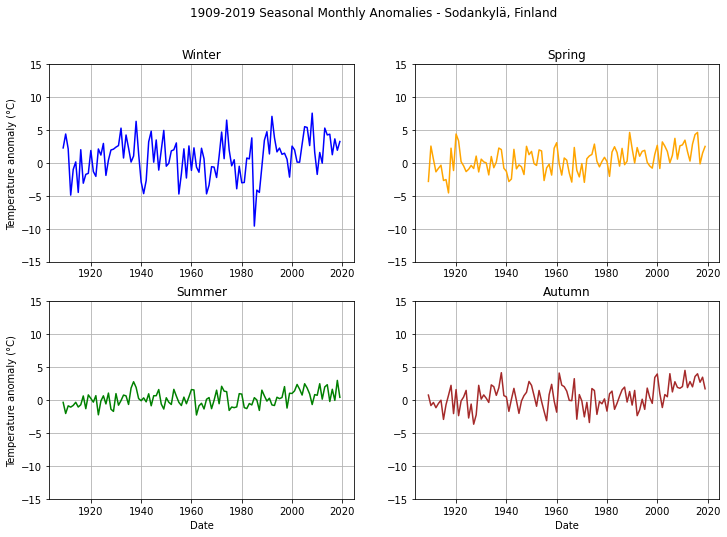

In [16]:
# Set the figure with subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Rename axes/subplot positions for convenience
ax11 = axs[0][0]
ax12 = axs[0][1]
ax21 = axs[1][0]
ax22 = axs[1][1]

# Plot the data in each subplot
winter.plot(ax=ax11, c="blue", ylim=[-15, 15], grid=True,legend=False)
spring.plot(ax=ax12, c="orange", ylim=[-15, 15], grid=True,legend=False)
summer.plot(ax=ax21, c="green", ylim=[-15, 15], grid=True,legend=False)
autumn.plot(ax=ax22, c="brown", ylim=[-15, 15], grid=True,legend=False)
    
# Set figure title
fig.suptitle("1909-2019 Seasonal Monthly Anomalies - Sodankylä, Finland")

# Axis labels
ax11.set_xlabel("")
ax12.set_xlabel("")
ax21.set_xlabel("Date")
ax22.set_xlabel("Date")
ax11.set_ylabel("Temperature anomaly (°C)")
ax21.set_ylabel("Temperature anomaly (°C)")

# subplot titles
ax11.title.set_text('Winter')
ax12.title.set_text('Spring')
ax21.title.set_text('Summer')
ax22.title.set_text('Autumn')

# Display plot
fig

# Save the plot as a png file:
outputfp = "output/seasonal_anomalies_Sodankyla.png"

# Save output plot
plt.savefig(outputfp)